In [6]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
library('IRdisplay')
if (!require(abind)) install.packages("abind")
library('abind')

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
source('Rfiles/3m_comparison.R')
clusterExport(cluster, "expo_gen_2stages")

# 3 Methods Comparison Under Proportional Hazard

### 2 stages Rejection region of overall:
### 1. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>c_1\ \&\ \frac{W}{\sigma}>c}$
### 2. Simple RMST Difference
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
### 3. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$
--------

#### <span style="color:yellow"> Setting in Jung's 2017 table 1 first row:
#### We set the total accrual time = 2 years and follow up 1 year
#### Recruit rate is 60(30 per arm) per year calculate the test power of 3 method controling $\alpha = 0.05$
#### <span style="color:yellow">We can only compare Minimax design since the default rule is searching for maximum stage I power


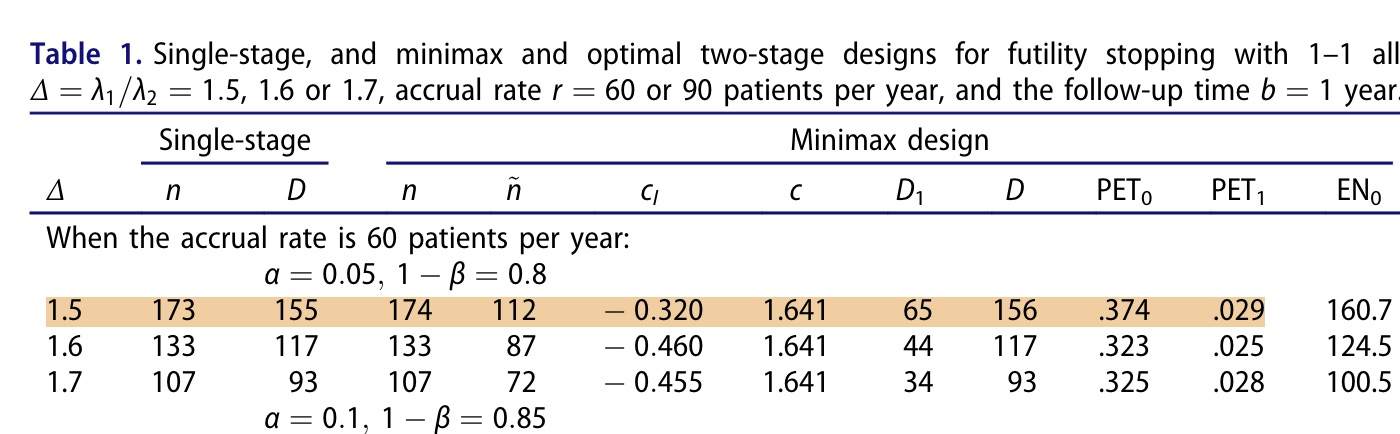

In [6]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

In [3]:
sim_size <- 5000
acc_time <- 174 / 60
cen_time <- 1
delta <- 1.5
lambda_H1 <- 0.9
lambda_H0 <- 0.9 * delta
r <- 60  # patient recruit rate
interim <- 2
n <- 174 / 2  # total sample size per arm
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)                    
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)

rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
#Log rank
z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], 
                                data_E = data_E_H0[ , c(2,3,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], 
                                data_E = data_E_H1[ , c(2,3,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], 
                                data_E = data_E_H0[ , c(4,5,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], 
                                data_E = data_E_H1[ , c(4,5,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

#Grid search critical value
search_times <- 500
#RMST
m_low <- quantile((rmst_data[2,] - rmst_data[1,]), 0.1)
# Smallest RMST difference: interim under H0
m_up <- quantile((rmst_data[8,] - rmst_data[7,]), 0.9)
# Largest RMST difference: final under H1
search_step_rmst <- (m_up - m_low) / search_times
t_low <- quantile((rmst_data[2,]), 0.1)
# Smallest experiment RMST: interim under H0
t_up <- quantile((rmst_data[8,]), 0.9)
#Log rank
c_low <- quantile(logrank_data, 0.2)
c_up <- quantile(logrank_data, 0.8)
search_step_lr <- (c_up - c_low) / search_times

# Control PET0 and PET1
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0.1  # lower bound of 1-PET1
tar_alpha <- 0.05

best_our_rmst <- find_m_t_RMST(m_low = m_low, t_low = t_low, t_up = t_up, rmst_data = rmst_data, 
                            search_times = search_times, search_step = search_step_rmst, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

best_simple_rmst <- find_m_t_RMST(m_low = m_low, t_low = -Inf, t_up = t_up, rmst_data = rmst_data, 
                            search_times = search_times, search_step = search_step_rmst, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

best_log_rank <- find_m_logrank(m_low = c_low, logrank_data = logrank_data, 
                            search_times = search_times, search_step = search_step_lr, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

list(best_our_rmst = best_our_rmst, 
    best_simple_rmst = best_simple_rmst,
    best_log_rank = best_log_rank)

$best_our_rmst
            m1        t1   PET0   PET1          m2        t2  alpha  Power
10% -0.1284839 0.6137693 0.3502 0.0078 -0.05440264 0.8484948 0.0498 0.9566

$best_simple_rmst
             m1   t1   PET0   PET1      m2   t2  alpha  Power
10% -0.03982928 -Inf 0.3508 0.0236 0.17027 -Inf 0.0488 0.8532

$best_log_rank
            m1   PET0   PET1       m2  alpha  Power
20% -0.2737572 0.3856 0.0236 1.642696 0.0494 0.7956

<span style="color:yellow">I pack all above up as a function to compare the result of 3 methods(3m_comparison.R)

## <span style="color:yellow">Grid search under a fixed interim period remarks:
### The searching range should be consistant under a specific experiment setting
###  1. Searching range of m (RMST difference):
#### $\qquad$ Lower bound slightly smaller than $E_1 - C_1|H_0\ $; Upper bound larger than $E_2 - C_2|H_1$
#### $\qquad$ upper bound is controled by m_low + search_times * search_step
### 2. Searching range of t (RMST of experiment group):
#### $\qquad$ t_low slightly smaller than $E_1\ $; t_up slightly larger than $E_2$
#### $\qquad$ search_step of t = (upper - lower) / searching times
### 3. Searching range of c (critical value of Log rank):
#### $\qquad$ Lower bound slightly smaller than $\frac{W_1}{\sigma_1}|H_0\ $; Upper bound larger than $\frac{W}{\sigma}|H_1$
### · <font color=LightSeaGreen>Control PET0 and overall alpha, search for the highest power for both stage
### Once the search_times is set, the running time is fixed. 

-----

# Differnent scenario

In [8]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(133 / 2)  # total sample size per arm
r <- 60  # patient recruit rate
acc_time <- 133 / r
cen_time <- 1
interim <- 87 / r
delta <- 1.6
lambda_H1 <- 0.9
lambda_H0 <- 0.9 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0.1  # lower bound of 1-PET1
tar_alpha <- 0.05

m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, interim = interim, 
        lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
        search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)

$best_our_rmst
            m1        t1   PET0  PET1          m2        t2 alpha  Power
10% -0.1253357 0.5388189 0.3512 0.011 -0.09722819 0.8062904 0.049 0.9598

$best_simple_rmst
            m1   t1   PET0   PET1        m2   t2  alpha Power
10% -0.0422908 -Inf 0.3528 0.0292 0.1749035 -Inf 0.0498 0.863

$best_log_rank
            m1   PET0  PET1       m2  alpha  Power
20% -0.2944743 0.3878 0.032 1.613483 0.0496 0.8058